https://arxiv.org/abs/2007.14044

In [343]:
!pip3 install qiskit --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [344]:
import qiskit
from scipy.special import erfinv
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split

qs = qiskit.Aer.get_backend('qasm_simulator')

# Useful functions

## Preprocessing functions

In [369]:
def qFactor(eps, d):
    #return erfinv(1-(eps**(1/d))/2)
    #return np.quantile(x, 1-(eps**(1/d))/2)
    return sp.stats.norm.ppf(1-(eps**(1/d))/2) 

def standardise(x):
    return (x - np.mean(x)) / np.std(x)

def rescaleFeature(x, alpha, q):
    return (1-alpha/2) * (np.pi/q) * standardise(x)

## Circuit functions

In [370]:
def psiGate(qc, param, bit):
    qc.rx(np.pi/2, bit)
    qc.rz(param, bit)
    qc.rx(np.pi/2, bit)

## Training functions

In [371]:
def executeJob(circuit, nshots):
    job = qiskit.execute(circuit, shots=nshots, backend=qs)
    job_results = job.result().get_counts()
    return job_results


In [372]:
def runCircuit(circuit_builder, loss_function, theta, x, y, nshots):
    omega = x
    label = y
    
    circuit = circuit_builder(theta, omega)
    job_results = executeJob(circuit, nshots)
    return loss_function(label, job_results, nshots)

In [373]:
def logSoftmax(label, job_results, nshots) :
    if label in job_results :
        e = np.exp(job_results[label] / nshots)
    else :
        e = 1
        
    s = np.exp(np.array(list(job_results.values())) / nshots).sum()
    return -np.log(e / s)


In [374]:
def lossBatch(circuit_builder, loss_function, theta, X, y, nshots):
    
    total_loss = 0
    
    batch = list(zip(X, y))
    
    for X_el, y_el in zip(X, y) :
        total_loss += runCircuit(circuit_builder, logSoftmax, theta, X_el, y_el, nshots)
        
    total_loss /= len(y)
    return total_loss

In [375]:
def fit(circuit_builder, loss_function, X, y, nshots=100, maxiter=20, theta=None, theta_size=8):
    if theta is None:
        theta = np.random.uniform(0, 2 * np.pi, theta_size)
        
    opt = sp.optimize.minimize(
        fun=lambda params : lossBatch(circuit_builder, loss_function, params, X, y, nshots),
        x0=theta,
        method='COBYLA',
        options={'maxiter': maxiter}
    )
    return opt

## Testing functions

In [376]:
def argmaxJobResults(job_results):
    max_label_value = None
    
    for label in job_results :
        if max_label_value is None or job_results[label] >= max_label_value:
            max_label = label
            max_label_value = job_results[label]
    return max_label

In [377]:
def prediction(circuit_builder, theta, omega, nshots):
    
    circuit = circuit_builder(theta, omega)
    job_results = executeJob(circuit, nshots)
    return argmaxJobResults(job_results)

In [378]:
def compute_accuracy(circuit_builder, theta, X, y, nshots=100) :
    correct = 0
    
    for X_el, y_el in zip(X, y) :
        y_pred = prediction(circuit_builder, theta, X_el, nshots)
        correct += y_pred == y_el
        
    return correct / len(y)

# IRIS

## Construct dataset

### Preprocess

In [379]:
df = pd.read_csv("iris.data")
df

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [380]:
alpha = 0.1
#eps = 0.01
#d = 4
#q = qFactor(eps, d)
q = 3

attributes = df.columns[:-1]

for x in attributes:
    df[x] = rescaleFeature(df[x], alpha, q)

df

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,Iris-setosa
1,-1.137116,-0.124313,-1.334348,-1.306199,Iris-setosa
2,-1.378201,0.336104,-1.390920,-1.306199,Iris-setosa
3,-1.498743,0.105896,-1.277776,-1.306199,Iris-setosa
4,-1.016574,1.256938,-1.334348,-1.306199,Iris-setosa
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,Iris-virginica
146,0.550477,-1.275354,0.702249,0.917304,Iris-virginica
147,0.791562,-0.124313,0.815393,1.048098,Iris-virginica
148,0.429934,0.796521,0.928537,1.440481,Iris-virginica


In [381]:
diconvert = {
    "Iris-setosa" : "00",
    "Iris-versicolor" : "01",
    "Iris-virginica" : "10",
    "NaN" : "11"
}

df = df.replace({"class": diconvert})
df

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,00
1,-1.137116,-0.124313,-1.334348,-1.306199,00
2,-1.378201,0.336104,-1.390920,-1.306199,00
3,-1.498743,0.105896,-1.277776,-1.306199,00
4,-1.016574,1.256938,-1.334348,-1.306199,00
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,10
146,0.550477,-1.275354,0.702249,0.917304,10
147,0.791562,-0.124313,0.815393,1.048098,10
148,0.429934,0.796521,0.928537,1.440481,10


In [382]:
X = df[attributes].values
y = df["class"].values

### Split

In [383]:
train_size = 90
test_size = 60

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, stratify=y)

## Circuit

In [384]:
def irisCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    iris_circuit = qiskit.QuantumCircuit(2)
    for i in range(4):
        if i : iris_circuit.cz(0, 1)
        psiGate(iris_circuit, omega[(2*i) % 4], 0)
        psiGate(iris_circuit, omega[(2*i+1) % 4], 1)
        iris_circuit.cz(0, 1)
        psiGate(iris_circuit, theta[(2*i)], 0)
        psiGate(iris_circuit, theta[(2*i+1)], 1)
        
    qc.append(iris_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

## Train

In [385]:
opt = fit(irisCircuit, logSoftmax, X_train, y_train, nshots=250, maxiter=20)
theta = opt.x
opt

     fun: 0.9899639270031846
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20
  status: 2
 success: False
       x: array([3.81193366, 5.6393256 , 5.99467633, 2.08830629, 3.97538269,
       2.58881831, 3.23745846, 6.54701623])

In [386]:
opt = fit(irisCircuit, logSoftmax, X_train, y_train, nshots=500, maxiter=30, theta=theta)
theta = opt.x
opt

     fun: 1.0011971884849833
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 30
  status: 2
 success: False
       x: array([3.8017314 , 5.63569207, 5.99166052, 2.09231511, 4.00200559,
       2.58593759, 3.23556474, 6.53636518])

In [387]:
opt = fit(irisCircuit, logSoftmax, X_train, y_train, nshots=750, maxiter=70, theta=theta)
theta = opt.x
opt

     fun: 0.9476511009253262
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 70
  status: 2
 success: False
       x: array([3.7173388 , 5.90776741, 5.73699847, 2.06926945, 4.27858888,
       2.86036542, 4.20711943, 6.92820264])

## Compute results

In [388]:
compute_accuracy(irisCircuit, theta, X_train, y_train)

0.8555555555555555

In [389]:
compute_accuracy(irisCircuit, theta, X_test, y_test)

0.7166666666666667

# Gaussian XOR

### Generate dataset

In [321]:
import numpy as np
import math

In [322]:
def generate_gaussian_point(x, y, label) :
    pick_x = np.random.normal(loc=x, scale = 0.5)
    pick_y = np.random.normal(loc=y, scale = 0.5)
    return (pick_x, pick_y, label)

In [323]:
point1 = (-np.pi / 2, 0)
point2 = (np.pi / 2, 0)
point3 = (0, -np.pi / 2)
point4 = (0, np.pi / 2)

centers = [point1, point2, point3, point4]


In [324]:
points = []
for i in range(20) :
    points.append(generate_gaussian_point(*point1, 0))
    points.append(generate_gaussian_point(*point2, 0))
    points.append(generate_gaussian_point(*point3, 1))
    points.append(generate_gaussian_point(*point4, 1))


(-3.141592653589793, 3.141592653589793)

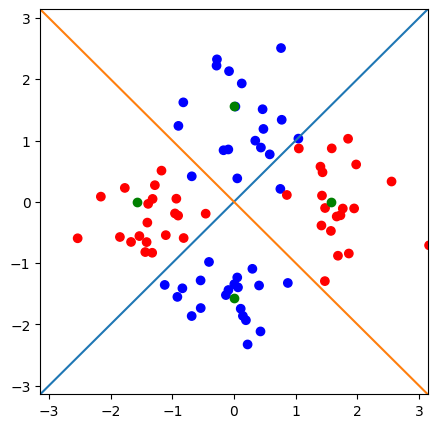

In [325]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5,5]

x,y,c = zip(*points)
c = ["red" if el==0 else "blue" for el in c]
plt.scatter(x, y, color=c)
x,y = zip(*centers)
plt.scatter(x, y, color='green')



x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [326]:
dataset = np.array(points)
dataset[:10]

array([[-1.84941587, -0.5748816 ,  0.        ],
       [ 1.68606489, -0.88054017,  0.        ],
       [ 0.43015675, -2.11598781,  1.        ],
       [ 0.47750572,  1.18863631,  1.        ],
       [-1.39149405, -0.03403082,  0.        ],
       [ 1.57177763, -0.47563214,  0.        ],
       [-0.40488997, -0.98195351,  1.        ],
       [-0.27587223,  2.3244836 ,  1.        ],
       [-1.53369834, -0.55957948,  0.        ],
       [ 1.76454086, -0.11026838,  0.        ]])

### Preprocess dataset

In [327]:
alpha = 0.1
eps = 0.01
d = 2
q = qFactor(eps, d)

dataset[:,0] = rescaleFeature(dataset[:,0], alpha, q)
dataset[:,1] = rescaleFeature(dataset[:,1], alpha, q)

X = dataset[:, :2]
X[:10]

array([[-3.46762069, -0.8308108 ],
       [ 2.8812608 , -1.41082589],
       [ 0.62594887, -3.75520084],
       [ 0.71097634,  2.5156258 ],
       [-2.64530215,  0.19550304],
       [ 2.6760281 , -0.64247586],
       [-0.87359617, -1.60326699],
       [-0.64191105,  4.67099995],
       [-2.90066718, -0.80177362],
       [ 3.02218495,  0.0508353 ]])

In [308]:
diconvert = {
    0 : "00",
    1 : "10",
}

y = [diconvert[x] for x in dataset[:,2]]
y[:10]

['00', '00', '10', '10', '00', '00', '10', '10', '00', '00']

### Split

In [309]:
train_size = 0.8
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, stratify=y)

## Circuit

In [310]:
def xorCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    xor_circuit = qiskit.QuantumCircuit(2)
    
    psiGate(xor_circuit, omega[0], 0)
    psiGate(xor_circuit, omega[1], 1)
    for i in range(2):
        xor_circuit.cz(0, 1)
        psiGate(xor_circuit, theta[2*i], 0)
        psiGate(xor_circuit, theta[2*i+1], 1)
        
    
    qc.append(xor_circuit, range(2))
    qc.measure(range(2), range(2))
    return qc

## Train

In [311]:
xor_opt = fit(xorCircuit, logSoftmax, X, y, nshots=250, maxiter=400, theta_size=4)
theta = xor_opt.x
xor_opt

     fun: 1.057958691471796
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 50
  status: 1
 success: True
       x: array([2.97737613, 5.9894224 , 6.22019141, 3.36530414])

## Compute results

In [312]:
compute_accuracy(xorCircuit, theta, X, y)

0.5125

In [320]:
prediction(xorCircuit, theta, [1, 0], 100)

'00'

## Compare with GaussianNB

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
gaussianNb = GaussianNB()
gaussianNb.fit(X_train, y_train)
score = gaussianNb.score(X_test, y_test)

In [40]:
score

1.0

# Skin segmentation

In [ ]:
def skinSegCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(3)
    psiGate(qc, omega[0], 0)
    psiGate(qc, omega[1], 1)
    psiGate(qc, omega[2], 2)
    
    qc.cz(0, 2)
    
    psiGate(qc, theta[0], 0)
    psiGate(qc, theta[1], 2)
    
    qc.cz(0, 1)
    
    psiGate(qc, theta[2], 0)
    psiGate(qc, theta[3], 1)
    
    qc.cz(1, 2)
    
    psiGate(qc, theta[4], 1)
    psiGate(qc, theta[5], 2)
    return qc

# Synthetic dataset with 4 classes

In [ ]:
def syntheticCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2)
    for i in range(2):
        if i : qc.cz(0, 1)
        psiGate(qc, omega[0], 0)
        psiGate(qc, omega[1], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i)], 0)
        psiGate(qc, theta[(6*i+1)], 1)
        qc.cz(0, 1)
        psiGate(qc, omega[0], 0)
        psiGate(qc, omega[1], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i+2)], 0)
        psiGate(qc, theta[(6*i+3)], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i+4)], 0)
        psiGate(qc, theta[(6*i+5)], 1)
    return qc

# Run on IBM Quantum Computer

In [ ]:
TOKEN = ...

In [ ]:
qiskit.IBMQ.save_account(TOKEN, overwrite=True) 
provider = qiskit.IBMQ.load_account()
backend = qiskit.providers.ibmq.least_busy(provider.backends())

mapped_circuit = qiskit.transpile(circuit, backend=backend)
qobj = qiskit.assemble(mapped_circuit, backend=backend, shots=1024)

IBMQAccountCredentialsInvalidToken: 'Invalid IBM Quantum Experience token found: "Ellipsis" of type <class \'ellipsis\'>.'

In [ ]:
# execute the circuit
job = backend.run(qobj)


In [ ]:
job.status()


In [ ]:
ID = job.job_id()

In [ ]:
job = backend.retrieve_job(ID)

In [ ]:
result = job.result()

In [ ]:
counts = result.get_counts()

In [ ]:
counts